In [2]:
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np

In [9]:
baba = pd.read_csv('BABA.csv', parse_dates = ['Date'], index_col = 'Date')
baba['EMA12'] = baba['Close'].ewm(span=12,min_periods=0,adjust=False,ignore_na=False).mean()
baba['EMA50'] = baba['Close'].ewm(span=50,min_periods=0,adjust=False,ignore_na=False).mean()
baba.head()

,Open,High,Low,Close,Adj Close,Volume,EMA12,EMA50
Date,,,,,,,,
2018-12-21,137.080002,137.190002,130.229996,132.000000,132.000000,28790600,132.000000,132.000000
2018-12-24,130.000000,134.570007,129.770004,131.889999,131.889999,11240700,131.983077,131.995686
2018-12-26,132.869995,138.020004,130.179993,138.000000,138.000000,14862400,132.908757,132.231150
2018-12-27,135.050003,138.449997,133.889999,138.449997,138.449997,11457400,133.761256,132.475026
2018-12-28,139.199997,140.979996,136.789993,139.089996,139.089996,11955300,134.581062,132.734436


In [10]:
#создадим дополнительный "черновой датафрейм"
baba_str = baba.copy()
#Если короткая EMA выше, то покупаем, наоборот продаём
baba_str['strategy_test'] = baba_str['EMA12'] > baba_str['EMA50']
#Сбрасываем повторяющиеся сигналы
baba_str['shifted'] = baba_str['strategy_test'].shift(1)
baba_str['buy'] = baba_str[baba_str['strategy_test'] != baba_str['shifted']]['strategy_test']
#Цена для стратегии - цена открытия следующего дня после сигнала
baba_str['open_shifted'] = baba_str['Open'].shift(-1)
baba_str['Strategy_Price'] = baba_str[baba_str['strategy_test'] != baba_str['shifted']]['open_shifted']
#Обнуляем первые 50 дней наблюдений из-за лага скользящей в Strategy_Price
baba_str.iloc[:50, 12] = np.nan
#Три дополнительных колонки для визульного отображения сделок
baba_str['b_triangle'] = baba_str[baba_str['buy'] == True]['Strategy_Price']
baba_str['s_triangle'] = baba_str[baba_str['buy'] == False]['Strategy_Price']
#Стоп-лосс 10% на каждую дату
baba_str['stoploss-b'] = baba_str[baba_str['buy'] == True]['Strategy_Price'].mul(0.9)
baba_str['stoploss-s'] = baba_str[baba_str['buy'] == False]['Strategy_Price'].mul(1.1)
baba_str['stoploss-b'] = baba_str['stoploss-b'].fillna(0)
baba_str['stoploss-s'] = baba_str['stoploss-s'].fillna(0)
baba_str['stoploss'] = baba_str['stoploss-b'] + baba_str['stoploss-s']
baba_str['stoploss'] = baba_str['stoploss'].replace(0, np.nan)
baba_str['stoploss'] = baba_str['stoploss'].fillna(method = 'ffill')

#тестовый вывод
#baba_str[(baba_str['buy'] == True) | (baba_str['buy'] == False)]

In [11]:
baba_str['sl'] = np.nan
baba_str['sl'] = baba_str[(((baba_str['strategy_test'] == True) & (baba_str['Low'] <= baba_str['stoploss'])) | 
                           ((baba_str['strategy_test'] == False) & (baba_str['High'] >= baba_str['stoploss'])))]['stoploss']



c:\python\python38-32\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


<IPython.core.display.Javascript object>


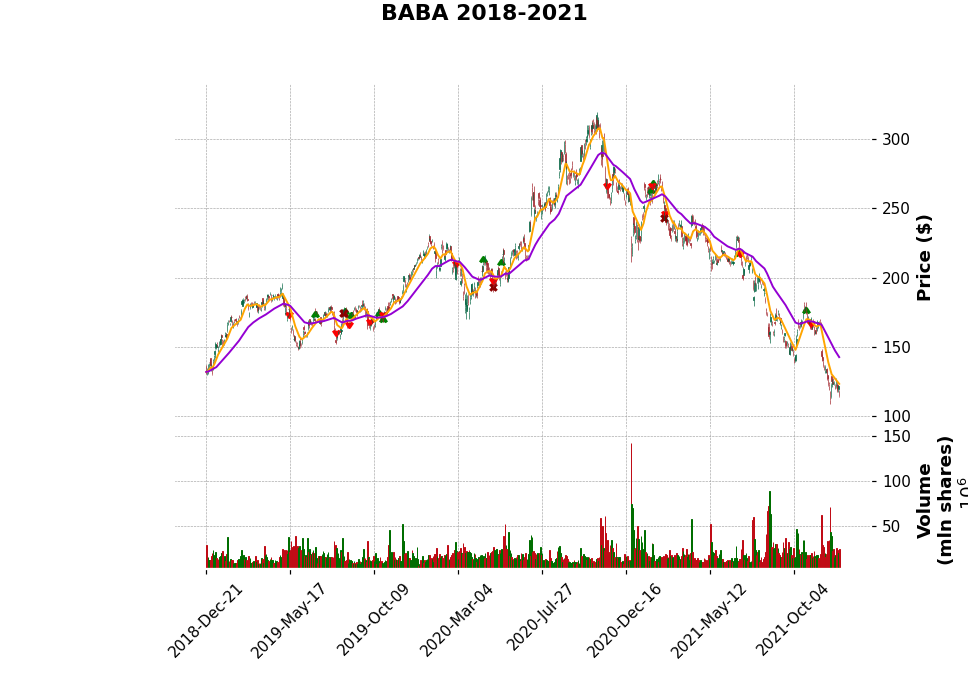

In [12]:
#если убрать параметр ylim, то у-оси будут слегка накладываться друг на друга, чисто косметический момент, необязательный
add = [mplf.make_addplot(baba['EMA12'], color = 'Orange',),
       mplf.make_addplot(baba['EMA50'], color = 'DarkViolet'),
       mplf.make_addplot(baba_str['b_triangle'], scatter=True, marker = 6, color = 'green'),
       mplf.make_addplot(baba_str['s_triangle'], scatter=True, marker = 7, color = 'r'),
       mplf.make_addplot(baba_str['sl'], scatter=True, marker = 'x', color = 'DarkRed')]

fig = mplf.plot(baba,
                type='candle', 
                style='charles',
                title='BABA 2018-2021', 
                ylabel='Price ($)', 
                volume=True, 
                ylabel_lower='Volume\n(mln shares)', 
                addplot = add,
                ylim = (90, 340))
mplf.show()

In [78]:
#Настраиваем табличку
money = 100000

deals = baba_str[['b_triangle', 's_triangle', 'sl']].dropna(how = 'all')
deals = deals[(~deals['sl'].duplicated()) | (deals['sl'].isnull())].fillna(0)
deals['Budget'] = 0
deals.iloc[0, 3] = 100000
deals.iloc[0, 1] = 0
deals = deals.rename(columns={'b_triangle': 'Buy_Price', 's_triangle': 'Sell_Price', 'sl': 'S/L_Price',})
deals['B_size'] = deals['Budget'].shift(1)//deals['Buy_Price']
deals['S_size'] = deals['B_size'].shift(1)
deals = deals.dropna(subset = ['B_size','S_size'], how = 'all')
deals['Sell_Price'] = deals['Sell_Price'].combine(deals['S/L_Price'], max)
deals['Buy_Date'] = deals.index
deals['Fix_Date'] = deals['Buy_Date'].shift(-1)
deals

,Buy_Price,Sell_Price,S/L_Price,Budget,B_size,S_size,Buy_Date,Fix_Date
Date,,,,,,,,
2019-07-01,175.130005,0.000000,0.000000,0,571.0,NaN,2019-07-01,2019-08-05
2019-08-05,0.000000,158.479996,0.000000,0,NaN,571.0,2019-08-05,2019-08-20
2019-08-20,177.220001,0.000000,0.000000,0,0.0,NaN,2019-08-20,2019-08-27
2019-08-27,0.000000,164.639999,0.000000,0,NaN,0.0,2019-08-27,2019-08-29
2019-08-29,174.350006,0.000000,0.000000,0,0.0,NaN,2019-08-29,2019-10-02
2019-10-02,0.000000,166.649994,0.000000,0,NaN,0.0,2019-10-02,2019-10-17
2019-10-17,176.000000,0.000000,0.000000,0,0.0,NaN,2019-10-17,2019-10-23
2019-10-23,0.000000,171.279999,0.000000,0,NaN,0.0,2019-10-23,2019-10-24
2019-10-24,171.559998,0.000000,0.000000,0,0.0,NaN,2019-10-24,2020-02-28


In [79]:
#deals_i.shape[0]

In [80]:
deals['Fix_Price'] = deals['Sell_Price'].shift(-1)
deals['Income'] = deals['Fix_Price'] - deals['Buy_Price'] 
deals_i = deals.dropna(subset = ['Income'])
deals_i['Income'].replace(0, np.nan, inplace = True)
deals_i.dropna(subset = ['Income'], inplace = True)
deals_i.drop(columns = ['Sell_Price', 'S/L_Price', 'S_size'], inplace = True)

for i in range(deals_i.shape[0]):
    deals_i['B_size'].iloc[i] = round(money / deals_i['Buy_Price'].iloc[i])
    deals_i['Budget'].iloc[i] = round(money + deals_i['Income'].iloc[i] * deals_i['B_size'].iloc[i], 2)
    money = deals_i['Budget'].iloc[i]
deals_i

c:\python\python38-32\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
c:\python\python38-32\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
c:\python\python38-32\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\pyth

,Buy_Price,Budget,B_size,Buy_Date,Fix_Date,Fix_Price,Income
Date,,,,,,,
2019-07-01,175.130005,90492.84,571.0,2019-07-01,2019-08-05,158.479996,-16.650009
2019-08-20,177.220001,84064.46,511.0,2019-08-20,2019-08-27,164.639999,-12.580002
2019-08-29,174.350006,80353.05,482.0,2019-08-29,2019-10-02,166.649994,-7.700012
2019-10-17,176.000000,78196.01,457.0,2019-10-17,2019-10-23,171.279999,-4.720001
2019-10-24,171.559998,95081.69,456.0,2019-10-24,2020-02-28,208.589996,37.029998
2020-04-16,214.979996,85579.57,442.0,2020-04-16,2020-05-01,193.481996,-21.498000
2020-05-15,212.500000,106624.23,403.0,2020-05-15,2020-11-12,264.720001,52.220001
2021-02-01,264.570007,106676.62,403.0,2021-02-01,2021-02-02,264.700012,0.130005
2021-02-03,269.579987,96001.25,396.0,2021-02-03,2021-02-23,242.621988,-26.957999


In [85]:
deals_i[['Buy_Date','Buy_Price', 'B_size','Fix_Date', 'Fix_Price', 'Budget']].style.hide_index()

Buy_Date,Buy_Price,B_size,Fix_Date,Fix_Price,Budget
2019-07-01 00:00:00,175.130005,571.000000,2019-08-05 00:00:00,158.479996,90492.840000
2019-08-20 00:00:00,177.220001,511.000000,2019-08-27 00:00:00,164.639999,84064.460000
2019-08-29 00:00:00,174.350006,482.000000,2019-10-02 00:00:00,166.649994,80353.050000
2019-10-17 00:00:00,176.000000,457.000000,2019-10-23 00:00:00,171.279999,78196.010000
2019-10-24 00:00:00,171.559998,456.000000,2020-02-28 00:00:00,208.589996,95081.690000
2020-04-16 00:00:00,214.979996,442.000000,2020-05-01 00:00:00,193.481996,85579.570000
2020-05-15 00:00:00,212.500000,403.000000,2020-11-12 00:00:00,264.720001,106624.230000
2021-02-01 00:00:00,264.570007,403.000000,2021-02-02 00:00:00,264.700012,106676.620000
2021-02-03 00:00:00,269.579987,396.000000,2021-02-23 00:00:00,242.621988,96001.250000
2021-07-01 00:00:00,219.160004,438.000000,2021-07-02 00:00:00,215.320007,94319.330000
